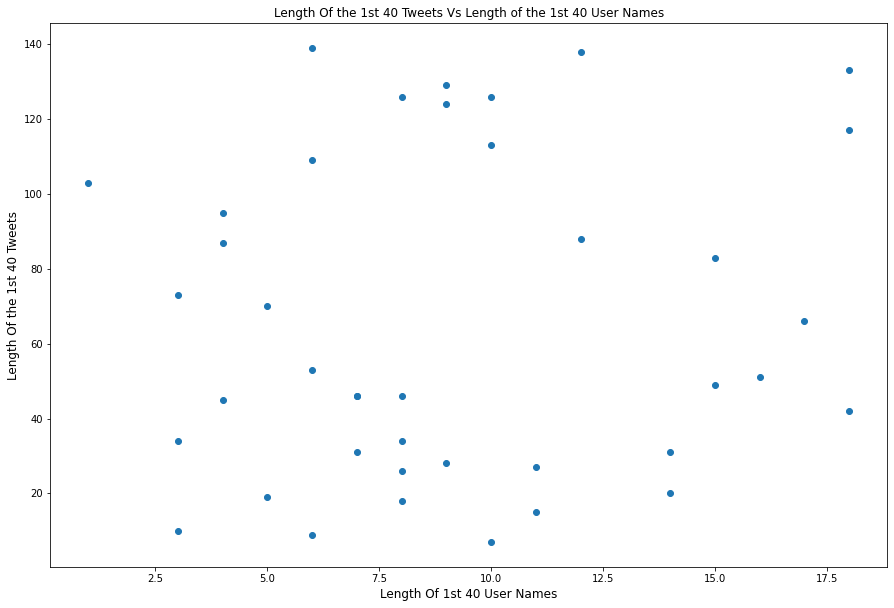

In [21]:
# Author: Ronaldlee Ejalu
# Course DSC 540
# Assignment module 9
# reading a collection of tweets data
# extending the schema by adding Geo table 
# also, added a foreign key relationship between Geo and Tweets. 
# converted SQL to Pandas
# derived a visualized plot using pandas Data Frame as my source data
# Part 1 e

import urllib.request
import json
import re
import sqlite3
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt


os.chdir('C:/Users/rejalu1/OneDrive - Henry Ford Health System/DSC450/Assignments/Week9')

tweetdata = """https://dbgroup.cdm.depaul.edu/DSC450/Module7.txt"""

createTbl1 = """
CREATE TABLE UserTweets 
(
    Id VARCHAR2(100),
    name VARCHAR2(100),
    screen_name VARCHAR2(300),
    description VARCHAR2(500),
    friends_count NUMBER,
    CONSTRAINT UserTweets_PK Primary Key(Id)
);
"""

createTbl2 = """
CREATE TABLE Tweets 
(	CREATED_AT DATE, 
	ID VARCHAR2(100), 
	TEXT VARCHAR2(300), 
	SOURCE VARCHAR2(100), 
	IN_REPLY_TO_USER_ID VARCHAR2(100), 
	IN_REPLY_TO_SCREEN_NAME VARCHAR2(100), 
	IN_REPLY_TO_STATUS_ID VARCHAR2(100), 
	RETWEET_COUNT NUMBER, 
	CONTRIBUTORS VARCHAR2(100),
    User_Id VARCHAR2(100),
    GeoId VARCHAR2(1000),
    CONSTRAINT TWEETS_FK1 FOREIGN KEY(User_Id) REFERENCES UserTweets(Id),
    CONSTRAINT TWEETS_FK2 FOREIGN KEY(GeoId) REFERENCES Geo(Id)
);
"""

createTbl3 = """
CREATE TABLE Geo
(
    Id VARCHAR2(1000),
    Type VARCHAR2(50),
    longitude NUMBER,
    latitude NUMBER,
    CONSTRAINT Geo_PK Primary Key (Id)
); 
"""

conn = sqlite3.connect('dsc450.db')                                                                        # open the connection
cur = conn.cursor()                                                                                        # instantiate a cursor object

# Drop the tables if they exist
cur.execute('DROP TABLE IF EXISTS UserTweets;')
cur.execute('DROP TABLE IF EXISTS Tweets;')
cur.execute('DROP TABLE IF EXISTS Geo;')

# execute the DDL to create the corresponding tables
cur.execute(createTbl1)
cur.execute(createTbl3)
cur.execute(createTbl2)


webFD = urllib.request.urlopen(tweetdata)

# read the file by using readlines(), which reads only one line assuming there are multiple lines
tweetLine = webFD.readlines()

csvf = open('ErrorFile.csv', 'w', newline='') 
count = 0
for i in range(0, len(tweetLine)):
    try:
        if tweetLine[i]:    # check if the item is empty before hand
            # tweetLine is a byte object which needs to be decoded. 
            # the loads() function in the json object lets you convert the string into the json object which acts like a dictionary. 
            # then decode the line that come back from the web into a string. 

            tDict  = json.loads(tweetLine[i].decode('utf-8'))                   # then decode the line that come back from the web into a string
            # print(type(tDict))

            cur.execute('INSERT OR IGNORE INTO UserTweets VALUES (?, ?, ?, ?, ?);', 
                                                                            (
                                                                                tDict['user']['id'], 
                                                                                tDict['user']['name'], 
                                                                                tDict['user']['screen_name'], 
                                                                                tDict['user']['description'], 
                                                                                tDict['user']['friends_count']
                                                                                )
                                                                )
            

            geoV = tDict['geo']
            if geoV is not None and (not isinstance(geoV, str) or geoV.strip()): # Check if the key is not None neither is it a string or blanck string
                geoValue = tDict['geo']['type'] + str(tDict['geo']['coordinates'][0]) + str(tDict['geo']['coordinates'][1])

                cur.execute('INSERT OR IGNORE INTO Geo VALUES (?, ?, ?, ?);', 
                                                        (
                                                            geoValue, 
                                                            tDict['geo']['type'], 
                                                            tDict['geo']['coordinates'][0], 
                                                            tDict['geo']['coordinates'][1])
                                                            )

                cur.execute('INSERT OR IGNORE INTO Tweets VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);', 
                                                                                        (
                                                                                            tDict['created_at'], 
                                                                                            tDict['id_str'], 
                                                                                            tDict['text'], 
                                                                                            tDict['source'], 
                                                                                            tDict['in_reply_to_user_id'], 
                                                                                            tDict['in_reply_to_screen_name'], 
                                                                                            tDict['in_reply_to_status_id'], 
                                                                                            tDict['retweet_count'], 
                                                                                            tDict['contributors'], 
                                                                                            tDict['user']['id'],
                                                                                            geoValue
                                                                                        )
                                                            )

                
                count = count + 1
            else:     # for the rest of the line items where the dictionary key, 'geo' is None
                cur.execute('INSERT OR IGNORE INTO Tweets VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);', 
                                                                                        (
                                                                                            tDict['created_at'], 
                                                                                            tDict['id_str'], 
                                                                                            tDict['text'], 
                                                                                            tDict['source'], 
                                                                                            tDict['in_reply_to_user_id'], 
                                                                                            tDict['in_reply_to_screen_name'], 
                                                                                            tDict['in_reply_to_status_id'], 
                                                                                            tDict['retweet_count'], 
                                                                                            tDict['contributors'], 
                                                                                            tDict['user']['id'],
                                                                                            None
                                                                                        )
                                                            )

    except ValueError:
        csvf.write(str(tweetLine[i]))                                          # write the problematic tweet to a file
    

userTweetItemsData = cur.execute('SELECT COUNT(*) FROM UserTweets;').fetchall()
tweetItemsData = cur.execute('SELECT length(Tweets.Text) AS [LengthOf1st40Tweets], length(UserTweets.name) AS [LengthOf1st40UserNames] FROM Tweets INNER JOIN UserTweets ON Tweets.User_Id = UserTweets.Id limit 40;').fetchall()
geoItemsData = cur.execute('SELECT COUNT(*) FROM Geo;').fetchall()


# SQL to Pandas DataFrame

queryScript = """SELECT length(Tweets.Text) AS [LengthOf1st40Tweets], length(UserTweets.name) AS [LengthOf1st40UserNames] FROM Tweets INNER JOIN UserTweets ON Tweets.User_Id = UserTweets.Id limit 40;""" 

sqlQueryObj = pd.read_sql_query(queryScript, conn)           # Read the sql query into a data frame

df = pd.DataFrame(sqlQueryObj, columns=['LengthOf1st40Tweets', 'LengthOf1st40UserNames'])       # create a data frame. 
# print(df)                                                 # For debugging purposes

fig = plt.figure()                                          # create a blank figure
#plt.xlim(xmin=0)                                            #

sp = fig.add_subplot(1, 1, 1)                                    # Add a grid of 1 subplot
fig.set_size_inches(15, 10)
sp.scatter(df['LengthOf1st40UserNames'], df['LengthOf1st40Tweets'])
fig
plt.xlabel("Length Of 1st 40 User Names", fontsize =12)                        # adding x-axis label
plt.ylabel("Length Of the 1st 40 Tweets", fontsize =12)                       # adding y-axis label

plt.title("Length Of the 1st 40 Tweets Vs Length of the 1st 40 User Names", fontsize = 12)      # add the title to the plot
fig.savefig('1e.pdf', bbox_inches='tight')                                  # save the file in pdf


csvf.close()
conn.commit()
conn.close()

   NumberOfTweets  RunTimeinSecs
0             500     173.371556
1              50       8.637104


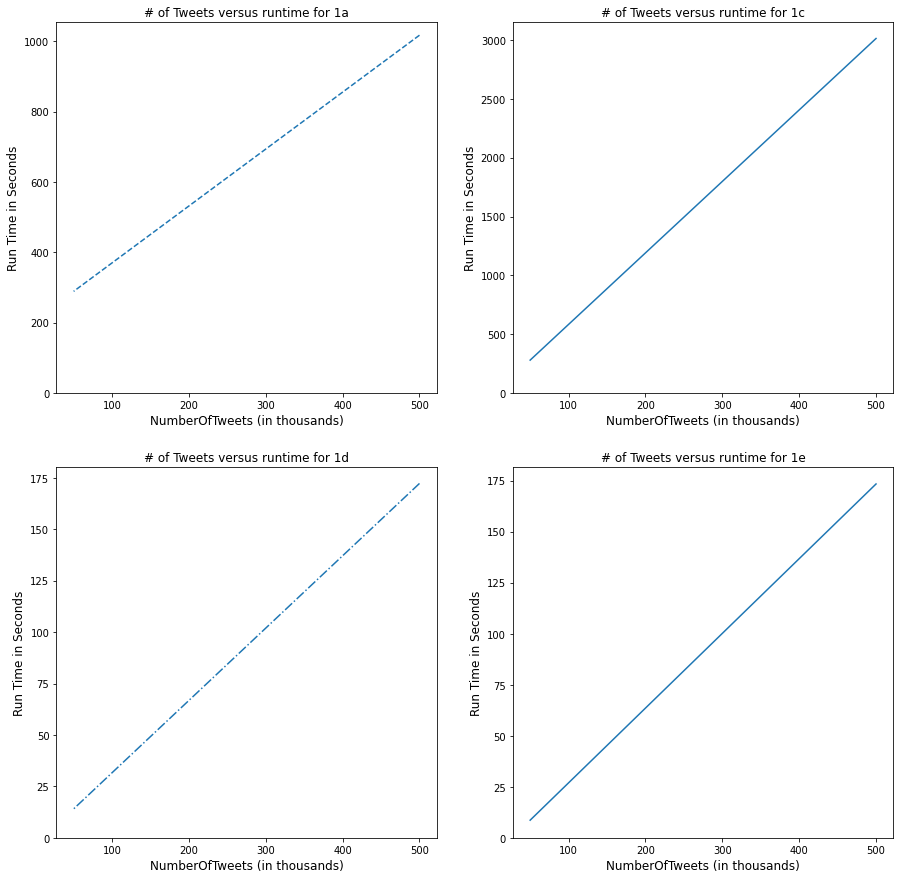

In [24]:
# Ronaldlee Ejalu
# DSC 450
# Final Take home exam
# plotting the resulting runtime (# of tweets versus run times)
# using matplotlib for 1-a, 1-c, 1-d, and 1-e
# 1f
import pandas as pd
import matplotlib.pyplot as plt
import os

os.chdir('C:/Users/rejalu1/OneDrive - Henry Ford Health System/DSC450/Assignments/FinalExamTakeHome')

# deriving the data structures for the runtimes of the number of tweets for the 
# questions 1a, 1c, 1d, and 1e
dataForA = [(500, 1016.9364602565765), (50, 288.94251561164856)]
dataForC = [(500, 3012.9960594177246), (50, 279.7146816253662)]
dataForD = [(500, 172.24891209602356), (50, 14.039840698242188)]
dataForE = [(500, 173.3715558052063), (50, 8.637104034423828)]

# derive the different data frames
dfRunTimeA = pd.DataFrame(dataForA, columns=['NumberOfTweets', 'RunTimeinSecs'])
dfRunTimeC = pd.DataFrame(dataForC, columns=['NumberOfTweets', 'RunTimeinSecs'])
dfRunTimeD = pd.DataFrame(dataForD, columns=['NumberOfTweets', 'RunTimeinSecs'])
dfRunTimeE = pd.DataFrame(dataForE, columns=['NumberOfTweets', 'RunTimeinSecs'])
print(dfRunTimeE)

fig = plt.figure()                                          # create a blank figure

# add a varierty of sub plots to it,
# the first two parameters describe the size of the grid
# that corresponds to the sub figures being added.
# 2 by 2 means we have a grid of four different sub plots
# and we are going to use that to compare and contrast the styles of the different figures. 
# the last parameter refers to which of the sub plots we are adding to.
# so one refers to the top left of the first out of the four subplots in the figure

sp = fig.add_subplot(2, 2, 1)                                    # Add a grid of 4 subplots
fig.set_size_inches(15, 15)                                      # set the figure size in inches. 

sp.plot(dfRunTimeA['NumberOfTweets'], dfRunTimeA['RunTimeinSecs'], '--')
sp.set_ylim(bottom=0)
sp.set_title("# of Tweets versus runtime for 1a", fontsize = 12)
sp.set_xlabel('NumberOfTweets (in thousands)', fontsize = 12)
sp.set_ylabel('Run Time in Seconds', fontsize = 12)


# creating a nother sub plot and we are using a 2 by 2 grid.
# in this case we are adding the secondor  top-right subplot to the figure 
# you can use different grading within the same figure but that does potentially 
# create overlay which you may or may not want to have in practice. 
# just note that is it possible but we will keep consistent grading into two-by-two
sp2 = fig.add_subplot(2, 2, 2) # so this addes the second sub plot to the top right
sp2.plot(dfRunTimeC['NumberOfTweets'], dfRunTimeC['RunTimeinSecs'], '-')
sp2.set_ylim(bottom=0)
sp2.set_title("# of Tweets versus runtime for 1c", fontsize = 12)                               # add the title to the plot                         
sp2.set_xlabel('NumberOfTweets (in thousands)', fontsize = 12)                                  # adding the x-axis label                     
sp2.set_ylabel('Run Time in Seconds', fontsize = 12)                                            # adding y-axis label

# next we add a third subplot and we are adding in the botton left, through the subplot
sp3 = fig.add_subplot(2, 2, 3) 
sp3.plot(dfRunTimeD['NumberOfTweets'], dfRunTimeD['RunTimeinSecs'],'-.') 
sp3.set_ylim(bottom=0)
sp3.set_title("# of Tweets versus runtime for 1d", fontsize = 12)                               # add the title to the plot                         
sp3.set_xlabel('NumberOfTweets (in thousands)', fontsize = 12)                                  # adding the x-axis label                     
sp3.set_ylabel('Run Time in Seconds', fontsize = 12)                                            # adding y-axis label
# sp3.set_ylim([15, 180])

# lets continue with fourth subplot
# Again, two by two adding to the fourth location over here
sp4 = fig.add_subplot(2, 2, 4)
sp4.plot(dfRunTimeE['NumberOfTweets'], dfRunTimeE['RunTimeinSecs']) 
sp4.set_ylim(bottom=0)
sp4.set_title("# of Tweets versus runtime for 1e", fontsize = 12)                               # add the title to the plot                         
sp4.set_xlabel('NumberOfTweets (in thousands)', fontsize = 12)                                  # adding the x-axis label                     
sp4.set_ylabel('Run Time in Seconds', fontsize = 12)                                            # adding y-axis label
#fig
fig.savefig('1e.pdf', bbox_inches='tight')                                  # save the file in pdf




